In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug  7 15:08:29 2020

@author: panpanhuang
"""

import numpy as np
import os
import dxchange
from tqdm import tqdm
from scipy.ndimage import rotate as sp_rotate
import xraylib as xlib
import xraylib_np as xlib_np
from functools import partial 
from multiprocessing import Pool

element_list = np.array(["H", "He",
                         "Li", "Be", "B", "C", "N", "O", "F", "Ne",
                         "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar",
                         "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr",
                         "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe",
                         "Cs", "Ba", "La",
                         "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
                                           "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn",
                         "Fr", "Ra", "Ac", 
                         "Th", "Pa", "U", "Np", "Pu", "Am"])



# xraylib uses keV
fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

fl_K_str = ["Ka1", "Ka2", "Ka3", "Kb1", "Kb2", "Kb3", "Kb4", "Kb5"]
fl_L_str = ["La1", "La2", "Lb1", "Lb2", "Lb3", "Lb4","Lb5", "Lb6",
             "Lb7", "Lb9", "Lb10", "Lb15", "Lb17"]
fl_Ma_str = ["Ma1", "Ma2", "Mb"]

fl_line_groups = np.array(["K", "L", "M"])


def attenuation(grid_concentration, theta_st, theta_end, n_theta, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    Calculate the attenuation ratio of the incident beam before the beam travels to a certain voxel.
    Assuming that the x-ray probe goes along the direction of axis=1 of the sample array.
    Calculate the transmission ratio at the exit of the sample.
    
    Parameters
    ----------
    grid_concentration: string
        the path of the elemental map
        
    theta_st: float
        The initial angle of the sample, in degree
        
    theta_end: float
        The final angle of the sample, in degree
    
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
    
    sample_size_cm: scalar
        sample size in cm
    
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    Returns: 2 ndarrays
    -------
        The 1st array is the attenuation ratio of the incident beam before the beam 
        travels to a certain voxel. Assuming that the x-ray probe goes along the direction
        of axis=1 of the sample array.
        dimension of the 1st returned array is (n_theta, sample_size_n, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
              
        The 2nd array is the transmission ratio of the incident beam at the exit of 
        the sample.
        dimension of the 2st returned array is (n_theta, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
    """
    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))
    
    probe_attCS_ls = xlib_np.CS_Total(aN_ls, probe_energy).flatten()
    probe_attCS_dic = dict(zip(element_ls, probe_attCS_ls))
    
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width
        att_exponent_acc_map = np.zeros((len(theta_ls), sample_size_n, sample_size_n + 1))
        for i, theta in enumerate(theta_ls):
            for j, element in enumerate(element_ls):
                concentration_map = grid_concentration[j]
                concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
                concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
                lac_single = concentration_map_rot * probe_attCS_dic[element]
                lac_acc = np.cumsum(lac_single, axis=1)
                lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
                att_exponent_acc = lac_acc * (sample_size_cm / (sample_size_n - 2 * padding_width))
                att_exponent_acc_map[i,:,:] += att_exponent_acc 
    else:
        att_exponent_acc_map = np.zeros((len(theta_ls), sample_size_n, sample_size_n+1))
        for i, theta in enumerate(theta_ls):
            for j, element in enumerate(element_ls):
                concentration_map = grid_concentration[j]
                concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
                lac_single = concentration_map_rot * probe_attCS_dic[element]
                lac_acc = np.cumsum(lac_single, axis=1)
                lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
                att_exponent_acc = lac_acc * (sample_size_cm / sample_size_n)
                att_exponent_acc_map[i,:,:] += att_exponent_acc   
                
    attenuation_map_flat = np.exp(-(att_exponent_acc_map[:,:,:-1].reshape(n_theta, sample_size_n * sample_size_n)))
    transmission = np.exp(-att_exponent_acc_map[:,:,-1])
    return attenuation_map_flat, transmission

def create_XRT_data(grid_concentration, theta_st, theta_end, n_theta, sample_size_n,
                         sample_size_cm, this_aN_dic, probe_energy, probe_cts, save_path, padding=True):
    """
    Parameters
    ----------
    grid_concentration: string
        the path of the elemental map
        
    theta_st: float
        The initial angle of the sample
        
    theta_end: float
        The final angle of the sample
    
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
    
    sample_size_cm: scalar
        sample size in cm
    
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.
        
    probe_cts : float
        The incident photon counts/s
    
    save_path : string
        The directory of saving the XRT_data

    Returns
    -------
    XRT_data : ndarray
        The dimension of the array is (n_theta, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
    """   
    XRT_data = probe_cts * attenuation(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy)[1]
       
    np.save(os.path.join(save_path, 'XRT_sample1.npy'), XRT_data)
    return XRT_data


def MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True):
    """   

    Parameters
    ----------
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.
        
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
        
    sample_size_cm: scalar
        sample size in cm
        
    fl_line_groups : ndarray, optional
        DESCRIPTION. The default is np.array(["K", "L", "M"]).
        
    fl_K : ndarray, optional
        The default is fl_K, an array of sub-lines of K line with the required format by xraylib.
        
    fl_L : ndarray, optional
        The default is fl_L, an array of sub-lines of L line with the required format by xraylib.
        
    fl_M : ndarray, optional
        The default is fl_M, an array of sub-lines of M line with the required format by xraylib.
        
    group_lines : boolean, optional
        Whether treating all K (or L, M) sub-lines as a single line. The default is True.

    Returns
    -------
    FL_all_elements_dic : dictionary
        The dictionary has 3 items. 
        1st item 
        key: "(element_name, Line)"
        value: an ndarray of ndarrays of 2 elements(type: string), [element symbol, line group]
        e.g. [['C', 'K'], ['O', 'K'], ['Si', 'K'], ['Si', 'L']]
        
        2nd item
        key: "fl_energy"
        value: float, Fluorescence energy in keV for each line of all element
        
        3rd item: "detected_fl_unit_concentration"
        key: fluorescence yield assuming a unit concentration [1 g/cm^3 ]
    """
    
    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))

    n_line_group = len(fl_line_groups)
    FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    voxel_size = sample_size_cm/sample_size_n

    fl_cs_K = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_K, probe_energy)
    fl_cs_L = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_L, probe_energy)
    fl_cs_M = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_M, probe_energy)
    
    # Remove the extra dimension with only 1 element
    fl_cs_K = np.reshape(fl_cs_K, (fl_cs_K.shape[:-1]))
    fl_cs_L = np.reshape(fl_cs_L, (fl_cs_L.shape[:-1]))
    fl_cs_M = np.reshape(fl_cs_M, (fl_cs_M.shape[:-1]))


    fl_energy_K = xlib_np.LineEnergy(aN_ls, fl_K)
    fl_energy_L = xlib_np.LineEnergy(aN_ls, fl_L)
    fl_energy_M = xlib_np.LineEnergy(aN_ls, fl_M)
    
    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    if group_lines == True:
        fl_energy_group = np.zeros((len(element_ls),n_line_group))
        fl_cs_group = np.zeros((len(element_ls),n_line_group))
        for i, element_name in enumerate(element_ls): 
        
            if np.sum(fl_energy_K[i] != 0):
                fl_energy_group[i,0] = np.average(fl_energy_K[i], weights=fl_cs_K[i]) 
                fl_cs_group[i,0] = np.sum(fl_cs_K[i])
            else:
                fl_energy_group[i,0] = 0
                fl_cs_group[i,0] = 0
        
            if np.sum(fl_energy_L[i] != 0):
                fl_energy_group[i,1] = np.average(fl_energy_L[i], weights=fl_cs_L[i]) 
                fl_cs_group[i,1] = np.sum(fl_cs_L[i])
            else:
                fl_energy_group[i,1] = 0
                fl_cs_group[i,1] = 0

            if np.sum(fl_energy_M[i] != 0):
                fl_energy_group[i,2] = np.average(fl_energy_M[i], weights=fl_cs_M[i]) 
                fl_cs_group[i,2] = np.sum(fl_cs_M[i])
            else:
                fl_energy_group[i,2] = 0
                fl_cs_group[i,2] = 0

            element_Line = fl_line_groups[fl_energy_group[i]!= 0]
            element_Line = [[element_name, element_Line[j]] for j in range(len(element_Line))]
            for k in range(len(element_Line)):
                FL_all_elements_dic["(element_name, Line)"].append(element_Line[k])     
        
            Line_energy = fl_energy_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], Line_energy)
        
            fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0] * voxel_size
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)
            
        FL_all_elements_dic["(element_name, Line)"] = np.array(FL_all_elements_dic["(element_name, Line)"])     
    return FL_all_elements_dic

## Calcualte FL_map, the emitted FL signal at each voxel for each elemental line given the intensity enters each voxel are all 1.
## The dimension of FL_map is (n_theta, sample_size * sample_size, n_elemental_line)
def generate_fl_signal_from_each_voxel(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    

    Parameters
    ----------
    grid_concentration : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    fl_map_tot : ndarray
        fl_map_tot shows the ratio of the probe that is converted into fl signal for each elemental line 
        at each theta at each translational position.
        The dimension of fl_map_tot is (n_theta, sample_size_n * sample_size_n, n_elemental_line)

    """
    element_ls = np.array(list(this_aN_dic.keys()))
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True)
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width      
        fl_map_tot = np.zeros((n_theta, sample_size_n * sample_size_n, len(fl_all_lines_dic["(element_name, Line)"])))
        for i, theta in enumerate(theta_ls):
            line_idx = 0
            for j, element in enumerate(element_ls):
                concentration_map = grid_concentration[j]
                concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
                concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
                concentration_map_rot_flat = concentration_map_rot.flatten()
                fl_unit = fl_all_lines_dic["detected_fl_unit_concentration"][fl_all_lines_dic["(element_name, Line)"][:,0] == element]
            
                ## FL signal over the current elemental lines for each voxel
                fl_map = np.array([concentration_map_rot_flat * fl_unit_single_line for fl_unit_single_line in fl_unit])
                fl_map = np.transpose(fl_map)
            
                fl_map_tot[i,:,line_idx:line_idx + fl_map.shape[1]] = fl_map
                line_idx = line_idx + len(fl_unit)
    return fl_map_tot   


## define a line passing through the FL emitting from the center of the source voxel (x1, y1) in the 2D sample 
## and the detectorlet (xd, yd)
def trace_beam_yint(x1, y1, xd, yd, sample_x_edge):
    m = (yd - y1)/(xd - x1)
    y_int = m * (sample_x_edge - x1) + y1
    return m, y_int

def trace_beam_xint(x1, y1, xd, yd, sample_y_edge):
    if yd == y1:
        m = 0
        x_int = np.array([])
    else:
        m = (yd - y1)/(xd - x1)
        x_int = (sample_y_edge - y1)/m + x1
    return m, x_int


## Calculate P (the intersecting length map): 
# 1. for each detectorlect (total n_det)
# 2. for each voxel (total sample_size x sample_size)
# 3. we have a 2D map of intersecting length (total sample_size x sample_size)

### The dimension of P:
# (n_det, sample_size * sample_size, sample_size * sample_size)
def intersecting_length_fl_detectorlet(n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, padding=True):
    
    voxel_size_cm = sample_size_cm/sample_size_n
    det_size_n = np.ceil(det_size_cm/voxel_size_cm)
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width
        x1, y1 = np.indices((sample_size_n, sample_size_n))
        
        ## x index of the location of the XRF detector
        det_axis_0_idx = (sample_size_n - padding_width) + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5
        det_axis_0_idx_ls = np.full(n_det, det_axis_0_idx)

    else:
        x1, y1 = np.indices((sample_size_n, sample_size_n))
        det_axis_0_idx = sample_size_n + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5
        det_axis_0_idx_ls = np.full(n_det, det_axis_0_idx)
   
    ## y index of the location of the XRF detector
    det_axis_1_idx_ls = np.linspace(np.ceil(sample_size_n/2 - det_size_n/2), 
                                      np.ceil(sample_size_n/2 + det_size_n/2), n_det) + 0.5
    

    ## biding x-index and y-index array into [(x1,y1), (x2,y2), ..., (x_Ndet, y_Ndet)]
    det_pos_ls = np.array(list(zip(det_axis_0_idx_ls, det_axis_1_idx_ls)))
    
    ## define sample edges: 
    ## sample_x_edge is the edge that is closer to the XRF detector
    ## sample_y_edge has two components representing the left and the right edge
    sample_x_edge = sample_size_n
    sample_y_edge = np.array([0, sample_size_n]) 
      
    ## define index position of center of the source voxel (x1, y1), note that it's shifted by 0.5 to represent the center
    x1, y1 = x1 + 0.5, y1 + 0.5
    voxel_pos_ls = np.dstack((x1, y1))

    ## make voxel_pos_ls 1D array for looping: voxel_pos_ls_flat
    voxel_pos_ls_flat =  np.reshape(voxel_pos_ls, (1, voxel_pos_ls.shape[0] * voxel_pos_ls.shape[1], 2))[0]

    P = np.zeros((n_det, sample_size_n * sample_size_n, sample_size_n * sample_size_n))
    for i, det_pos in enumerate(det_pos_ls):
        for j, v in enumerate(voxel_pos_ls_flat):
            # find x-value when the beam passes the sample WITHOUT intersecting the sample_y_edges(left & right), namely the beam is parallel with the y edge of the sample. 
            # find x-value when the beam passes through sample_y_edges(left & right), the one with larger x is the intersection with lower edge
            if v[1] == det_pos[1]:
                xint = sample_size_n
            else:
                xint = np.max(trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], sample_y_edge)[1])
            xint_sample = np.clip(xint, 0, sample_size_n)
        
            # find y-value when the beam passes through sample_x_edge(bottom)
            m = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[0]
            yint = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], sample_x_edge)[1]
            yint_sample = np.clip(yint, 0, sample_size_n)
    
               
            # when the beam intersects with a voxel, it either intersects with the x boundary or y boundary of the voxel
            # find the x,y-value of the boundary except the ones on the sample edge
            if np.floor(xint_sample) != np.floor(v[0]):
                x_edge_ls = np.linspace(np.ceil(xint_sample)-1, np.ceil(v[0]), int(np.abs(np.ceil(xint_sample) - np.ceil(v[0]))))
            else: 
                x_edge_ls = np.array([])
            
        
            if np.floor(yint_sample) != np.floor(v[1]):            
                if m < 0:
                    y_edge_ls = np.linspace(np.floor(yint_sample)+1, np.floor(v[1]), int(np.abs(np.floor(yint_sample)+1 - np.floor(v[1]))) + 1)            
           
                if m > 0:
                    y_edge_ls = np.linspace(np.ceil(yint_sample)-1, np.ceil(v[1]), int(np.abs(np.ceil(yint_sample) - np.ceil(v[1]))))
            else:
                y_edge_ls = np.array([])
        
        
            # find all intersections (except the initial intersection): 
            # 1. find y-value of intersection given x_edge_ls
            # 2. find x-value of intersection given y_edge_ls
            y_int_x_edge_ls = trace_beam_yint(v[0], v[1], det_pos[0], det_pos[1], x_edge_ls)[1] #solve y intersections given x edge
            x_int_y_edge_ls = trace_beam_xint(v[0], v[1], det_pos[0], det_pos[1], y_edge_ls)[1] #solve x intersections given y edge
        
            # compile the x,y coordinates of the intersection: (x,y) = (x_edge_ls, y_int_x_edge_ls) and (x_int_y_edge_ls,y_edge_ls)
            int_x_edge_ls = np.dstack((x_edge_ls,y_int_x_edge_ls))[0]
            int_y_edge_ls = np.dstack((x_int_y_edge_ls,y_edge_ls))[0]

            # sort them using the x coordinate
            int_ls = np.concatenate((int_x_edge_ls, int_y_edge_ls))
            int_ls = np.vstack((np.array([xint_sample, yint_sample]), int_ls))
            int_ls = int_ls[np.argsort(int_ls[:,0])]
        
            # calculate the intersecting length in the intersecting voxels
            int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2) 
            # just in case that we count some intersections twice, delete the duplicates
            idx_duplicate = np.array(np.where(int_length==0)).flatten()
            int_ls = np.delete(int_ls, idx_duplicate, 0)
            int_length = np.delete(int_length, idx_duplicate) 
        
            # determine the indices of the intersecting voxels according to the intersecting x,y-coordinates
            int_ls_shift = np.zeros((int_ls.shape))
            int_ls_shift[1:] = int_ls[:-1]
            int_idx = np.floor((int_ls_shift + int_ls_shift)/2)[1:]        
            int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'))
        
            # construct the int_length_map, and scale the intersecting length based on the voxel size
            int_length_map = np.zeros((sample_size_n, sample_size_n))
            int_length_map[int_idx] = int_length * voxel_size_cm  
         
            P[i, j, :] = int_length_map.flatten()
    return P


### 3-1: Calculate SA (the map of attenuation ratio due to self-absorption of the FL signal):
# 1. for each sample angle (n_theta)
# 2. for each FL emitting voxel (sample_size x sample_size),
# 3. we have an attenuation ratio when the photon for each elemental line reaches the edge of the sample (due to self absorption) (n_elemental_line)

#### The dimension of SA:
# (n_theta, sample_size * sample_size, n_elemental_line)
    
#### To construct different theta in parallel, I first construct a function that runs single theta. Then wrap this function by another function to run several values of theta in parallel
def self_absorption_att_ratio_single_theta(grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, 
                                       this_aN_dic, probe_energy, theta, padding=True):
    """
    

    Parameters
    ----------
    grid_concentration : TYPE
        DESCRIPTION.
    det_size_n : TYPE
        DESCRIPTION.
    det_size_cm : TYPE
        DESCRIPTION.
    det_from_sample_cm : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    theta : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    SA_theta : ndarrsy
        dimension: (sample_size_n * sample_size_n, n_elemental_line)

    """
    aN_ls = np.array(list(this_aN_dic.values()))
    element_ls = np.array(list(this_aN_dic.keys()))    
    
    P = intersecting_length_fl_detectorlet(n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, padding=True)
    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True)   
    
    # generate an arrary of total attenuation cross section with the dimension: (n_element, n_elemental_lines)
    # The component in the array represents the total attenuation cross section at some line energy in some element (with unitary concentration)
    FL_line_attCS_ls = xlib_np.CS_Total(aN_ls, fl_all_lines_dic["fl_energy"])
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width
    
        SA_theta = np.zeros((sample_size_n * sample_size_n, len(fl_all_lines_dic["(element_name, Line)"])))
        for j in tqdm(np.arange(sample_size_n * sample_size_n)):       
            att_exponent_elemental_sum_temp = np.zeros((len(element_ls), n_det, len(fl_all_lines_dic["(element_name, Line)"])))
            for k, element in enumerate(element_ls):
                concentration_map = grid_concentration[k]
                concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
                concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
                ## flattened concentration_map after rotation: (sample_size_n * sample_size_n)
                concentration_map_rot_flat = concentration_map_rot.flatten()
            
                ## llinear attenuation coefficient for each fl-line at each voxel: (sample_size * sample_size, len(fl_lines_all["(element_name, Line)"]))
                lac = np.array([FL_line_attCS * concentration_map_rot_flat for FL_line_attCS in FL_line_attCS_ls[k]])
                lac = np.transpose(lac)
            
                ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
                ## att_exponent (for each fl-line, at each_voxel, for each beam path): (n_det, sample_size * sample_size, len(fl_lines_all["(element_name, Line)"]))
                att_exponent = np.array([P[m,j,:][:,np.newaxis] * lac for m in range(n_det)])
            
                ## att_exponent summing over voxels (for each line, for each beam path): (n_det, n_elemental_line)
                att_exponent_voxel_sum = np.sum(att_exponent, axis=1)

                ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element
                att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum
        
            ## summing over the attenation exponent contributed by each element
            att_exponent_elemental_sum =  np.sum(att_exponent_elemental_sum_temp, axis=0) 
        
        
            ## calculate the attenuation caused by all elements
            att = np.exp(- att_exponent_elemental_sum)
            ## calculate the attenuation averaged all paths
            att_path_ave = np.average(att, axis=0)
            SA_theta[j,:] = att_path_ave
        
    return SA_theta


def self_absorption_att_ratio(n_thread, theta_st, theta_end, n_theta, grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, 
                                       this_aN_dic, probe_energy, padding=True):
    
    pfunc = partial(self_absorption_att_ratio_single_theta, grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding=True)
    theta_ls = - np.linspace(theta_st, theta_end, n_theta) 
    with Pool(n_thread) as p:
        SA = np.array(p.map(pfunc, theta_ls))    
    return SA


def create_probe_before_attnuation_flat(sample_size_n, probe_cts, padding=True):
    """
    Parameters
    ----------
    sample_size_n : TYPE
        DESCRIPTION.
    probe_cts : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    probe_before_attnuation_flat : ndarray
        photon counts that enter each voxel without attenuation. dimension: (sample_size_n * sample_size_n)
    """
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width      
        probe_before_attnuation_flat = probe_cts * np.ones((sample_size_n * sample_size_n))
    return probe_before_attnuation_flat

def create_probe_after_attenuation_flat(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts, padding=True):      
    """

    Parameters
    ----------
    grid_concentration : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    probe_cts : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    probe_after_attenuation_flat : ndarray
        photon counts that enter each voxel at each theta after attenuation. dimension: (n_theta, sample_size_n * sample_size_n)

    """
    probe_before_attenuation_flat = create_probe_before_attnuation_flat(sample_size_n, probe_cts, padding)
    att_ratio_map_flat = attenuation(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding)[0]
    probe_after_attenuation_flat = probe_before_attenuation_flat * att_ratio_map_flat
    return probe_after_attenuation_flat



## generate the XRF data with dimension: (n_theta, n_translational_pos, n_elemental_line)
def create_XRF_data(n_thread, theta_st, theta_end, n_theta, grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n,
                    sample_size_cm, this_aN_dic, probe_cts, probe_energy, save_path, padding=True):      
    
    # (n_theta, sample_size_n * sample_size_n)
    probe_after_attenuation = create_probe_after_attenuation_flat(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts, padding)
    
    #(n_theta, sample_size_n * sample_size_n, n_elemental_line)
    fl_ratio_map_tot = generate_fl_signal_from_each_voxel(grid_concentration, theta_st, theta_end, n_theta, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding)
    
    #elemental lines in cts generated at each voxel position (before going through self-absorption). dimension: (n_theta, sample_size * sample_size, n_elemental_line)
    fl_signal_wo_SA = probe_after_attenuation[:,:,np.newaxis] * fl_ratio_map_tot
    
    #Calculate signal attenuation after self-absorption. dimension: (n_theta, sample_size * sample_size, n_elemental_line)
    SA_att_ratio = self_absorption_att_ratio(n_thread, theta_st, theta_end, n_theta, grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, 
                                       this_aN_dic, probe_energy, padding=True)
       
    #calculate fluorescence after self-absorption. dimension: (n_theta, len(smaple.shape[0]), n_elemental_line)
    fl_signal_SA = fl_signal_wo_SA * SA_att_ratio
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width       
        fl_signal_SA = fl_signal_SA.reshape(n_theta, sample_size_n, sample_size_n, -1)
        fl_signal_SA = np.sum(fl_signal_SA, axis=2)
    
    np.save(os.path.join(save_path, 'XRF_sample1.npy'), fl_signal_SA)
    return fl_signal_SA
    
##############################################################################
### Functions below are made for creating predicted data at a single theta ###
##############################################################################
    
def attenuation_theta(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    Calculate the attenuation ratio of the incident beam before the beam travels to a certain voxel.
    Assuming that the x-ray probe goes along the direction of axis=1 of the sample array.
    Calculate the transmission ratio at the exit of the sample.
    
    Parameters
    ----------
    grid_concentration: string
        the path of the elemental map
        
    theta_st: float
        The initial angle of the sample, in degree
        
    theta_end: float
        The final angle of the sample, in degree
    
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
    
    sample_size_cm: scalar
        sample size in cm
    
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    Returns: 2 ndarrays
    -------
        The 1st array is the attenuation ratio of the incident beam before the beam 
        travels to a certain voxel. Assuming that the x-ray probe goes along the direction
        of axis=1 of the sample array.
        dimension of the 1st returned array is (n_theta, sample_size_n, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
              
        The 2nd array is the transmission ratio of the incident beam at the exit of 
        the sample.
        dimension of the 2st returned array is (n_theta, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
    """
    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))
    
    probe_attCS_ls = xlib_np.CS_Total(aN_ls, probe_energy).flatten()
    probe_attCS_dic = dict(zip(element_ls, probe_attCS_ls))
    
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width
        att_exponent_acc_map = np.zeros((sample_size_n, sample_size_n + 1))
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(grid_concentration, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            lac_single = concentration_map_rot * probe_attCS_dic[element]
            lac_acc = np.cumsum(lac_single, axis=1)
            lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
            att_exponent_acc = lac_acc * (sample_size_cm / (sample_size_n - 2 * padding_width))
            att_exponent_acc_map += att_exponent_acc 
    else:
        att_exponent_acc_map = np.zeros((sample_size_n, sample_size_n+1))
        for j, element in enumerate(element_ls):
            concentration_map_fname = os.path.join(grid_concentration, element + '_map.tiff')
            concentration_map = dxchange.reader.read_tiff(concentration_map_fname)
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            lac_single = concentration_map_rot * probe_attCS_dic[element]
            lac_acc = np.cumsum(lac_single, axis=1)
            lac_acc = np.insert(lac_acc, 0, np.zeros(concentration_map.shape[0]), axis=1)
            att_exponent_acc = lac_acc * (sample_size_cm / sample_size_n)
            att_exponent_acc_map += att_exponent_acc   
                
    attenuation_map_theta_flat = np.exp(-(att_exponent_acc_map[:,:-1].reshape(sample_size_n * sample_size_n)))
    transmission_theta = np.exp(-att_exponent_acc_map[:,-1])
    return attenuation_map_theta_flat, transmission_theta
    
def create_probe_after_attenuation_theta_flat(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts, padding=True):      
    """

    Parameters
    ----------
    grid_concentration : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    probe_cts : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    probe_after_attenuation_flat : ndarray
        photon counts that enter each voxel at some theta after attenuation. dimension: (sample_size_n * sample_size_n)

    """
    probe_before_attenuation_flat = create_probe_before_attnuation_flat(sample_size_n, probe_cts, padding)
    att_ratio_map_theta_flat = attenuation_theta(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, 
                                                 sample_size_cm, this_aN_dic, probe_energy, padding)[0]
    probe_after_attenuation_theta_flat = probe_before_attenuation_flat * att_ratio_map_theta_flat
    return probe_after_attenuation_theta_flat
   
def generate_fl_signal_from_each_voxel_theta(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding=True):
    """
    Parameters
    ----------
    grid_concentration : TYPE
        DESCRIPTION.
    theta_st : TYPE
        DESCRIPTION.
    theta_end : TYPE
        DESCRIPTION.
    n_theta : TYPE
        DESCRIPTION.
    sample_size_n : TYPE
        DESCRIPTION.
    sample_size_cm : TYPE
        DESCRIPTION.
    this_aN_dic : TYPE
        DESCRIPTION.
    probe_energy : TYPE
        DESCRIPTION.
    padding : TYPE, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    fl_map_tot : ndarray
        fl_map_tot shows the ratio of the probe that is converted into fl signal for each elemental line 
        at each theta at each translational position.
        The dimension of fl_map_tot is (sample_size_n * sample_size_n, n_elemental_line)

    """
    element_ls = np.array(list(this_aN_dic.keys()))
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True)
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width      
        fl_map_tot_theta = np.zeros((sample_size_n * sample_size_n, len(fl_all_lines_dic["(element_name, Line)"])))
        line_idx = 0
        for j, element in enumerate(element_ls):
            concentration_map = grid_concentration[j]
            concentration_map = np.pad(concentration_map, (padding_width, padding_width), mode="constant", constant_values=(0,0))
            concentration_map_rot = sp_rotate(concentration_map, theta, reshape=False, order=1)
            concentration_map_rot_flat = concentration_map_rot.flatten()
            fl_unit = fl_all_lines_dic["detected_fl_unit_concentration"][fl_all_lines_dic["(element_name, Line)"][:,0] == element]
            
            ## FL signal over the current elemental lines for each voxel
            fl_map = np.array([concentration_map_rot_flat * fl_unit_single_line for fl_unit_single_line in fl_unit])
            fl_map = np.transpose(fl_map)
            
            fl_map_tot_theta[:,line_idx:line_idx + fl_map.shape[1]] = fl_map
            line_idx = line_idx + len(fl_unit)
    return fl_map_tot_theta  


def create_XRF_data_single_theta(theta_st, theta_end, n_theta, this_theta_idx, grid_concentration, n_det, det_size_cm, det_from_sample_cm,
                                 sample_size_n, sample_size_cm, this_aN_dic, probe_cts, probe_energy, save_path, padding=True):
    
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)
    theta = theta_ls[this_theta_idx]
    
    probe_after_attenuation_theta = create_probe_after_attenuation_theta_flat(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, probe_cts)
    fl_ratio_map_tot_theta = generate_fl_signal_from_each_voxel_theta(grid_concentration, theta_st, theta_end, n_theta, this_theta_idx, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, padding)    
    fl_signal_wo_SA_theta = probe_after_attenuation_theta[:, np.newaxis] * fl_ratio_map_tot_theta
    
    SA_att_ratio_theta = self_absorption_att_ratio_single_theta(grid_concentration, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, 
                                       this_aN_dic, probe_energy, theta, padding)    
    fl_signal_SA_theta = fl_signal_wo_SA_theta * SA_att_ratio_theta
    
    if padding is True:
        padding_width = int(np.ceil(0.5 * (np.sqrt(2)-1) * sample_size_n))
        sample_size_n = sample_size_n + 2 * padding_width       
        fl_signal_SA_theta = fl_signal_SA_theta.reshape(sample_size_n, sample_size_n, -1)
        fl_signal_SA_theta = np.sum(fl_signal_SA_theta, axis=1)
    
    np.save(os.path.join(save_path, 'XRF_theta_{}_sample1.npy'.format(theta)), fl_signal_SA_theta)
    return fl_signal_SA_theta
    
    


            

In [3]:
P = intersecting_length_fl_detectorlet(5, 0.24, 1.6, 20, 0.01, padding=True)
print(P.shape)
P_re = P.reshape(5,30,30,30,30)
print(P_re.shape)

(5, 900, 900)
(5, 30, 30, 30, 30)


In [4]:
import matplotlib.pyplot as plt

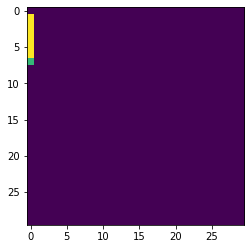

In [12]:
plt.imshow(P_re[0,0,0])